In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy

In [2]:
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=True, format="pdf")
sc.settings.verbosity = 3

-----
anndata     0.7.5
scanpy      1.8.1
sinfo       0.3.1
-----
OpenSSL             20.0.1
PIL                 8.1.1
anndata             0.7.5
anyio               NA
appdirs             1.4.4
argon2              20.1.0
asciitree           NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bioservices         1.7.11
boto3               1.20.24
botocore            1.23.24
brotli              NA
bs4                 4.9.3
bson                NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.3.0
colorama            0.4.4
colorlog            NA
cryptography        3.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
docutils            0.16
easydev             0.11.0
fasteners           NA
future_fstrings     NA
google              NA
gridfs     

In [3]:
heart_infection_sc_no_viral_genes = sc.read_h5ad(filename="./../pyobjs/heart_infection_sc_4samples_no_viral_genes.h5ad")
heart_infection_sc_no_viral_genes

OSError: Unable to open file (unable to open file: name = './../pyobjs/heart_infection_sc_4samples_no_viral_genes.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [9]:
samples = ['Mock-Heart-D4PI', 'T1L-Heart-D4PI', 'Mock-Heart-D7PI', 'T1L-Heart-D7PI']

In [ ]:
stage_data_visium = list()

for sample in samples:
    print(sample)
    data_visium = sc.read_visium(path="./../spatialData/" + sample + "/outs/")
    data_visium.var_names_make_unique()
    print(data_visium)
    
    reoviral_genes = [name for name in data_visium.var_names if name.startswith('Reo')]
    print(reoviral_genes)
    viral_expression = data_visium[:,reoviral_genes].to_df()
    viral_expression.columns = [x.split("_")[1] for x in viral_expression.columns]
    reoviral_genes_indicator = np.in1d(data_visium.var_names, reoviral_genes)
    data_visium_no_viral_genes = data_visium[:, ~reoviral_genes_indicator]
    data_visium_no_viral_genes.var_names = [name.split("_")[1] for name in data_visium_no_viral_genes.var_names]
    data_visium_no_viral_genes.obs.join(viral_expression.astype(int))
    print(data_visium_no_viral_genes.shape)

    data_visium_no_viral_genes.obs_names_make_unique()
    data_visium_no_viral_genes.var_names_make_unique()

    sc.pp.filter_cells(data_visium_no_viral_genes, min_counts=1)
    sc.pp.filter_genes(data_visium_no_viral_genes, min_cells=1)

    data_visium_no_viral_genes.var['mt'] = data_visium_no_viral_genes.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(data_visium_no_viral_genes, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    sc.pp.normalize_total(data_visium_no_viral_genes, inplace=True)
    sc.pp.log1p(data_visium_no_viral_genes)

    data_visium_no_viral_genes.raw = data_visium_no_viral_genes
    print(data_visium_no_viral_genes.shape)
   
    sc.pp.scale(data_visium_no_viral_genes, max_value=10)
    sc.pp.pca(data_visium_no_viral_genes)
    sc.pp.neighbors(data_visium_no_viral_genes, n_pcs=20)
    sc.tl.umap(data_visium_no_viral_genes)
    sc.tl.leiden(data_visium_no_viral_genes, key_added="leiden_0.5", resolution = 0.5)
    sc.tl.leiden(data_visium_no_viral_genes, key_added="leiden_0.8", resolution = 0.8)
    data_visium_no_viral_genes.obs["sample"] = sample
    
    stage_data_visium.append(data_visium_no_viral_genes)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, library in enumerate(stage_data_visium):
    ad = library.copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=samples[i],
        color="leiden_0.8",
        size=1.5,
        scale_factor=1.0,
        show=False,
        ax=axs[i],
    )
plt.tight_layout()

In [ ]:
stage_data_visium[0].write_h5ad(filename="./../pyobjs/Mock_heart_D4PI.h5ad")
stage_data_visium[1].write_h5ad(filename="./../pyobjs/T1L_heart_D4PI.h5ad")
stage_data_visium[2].write_h5ad(filename="./../pyobjs/Mock_heart_D7PI.h5ad")
stage_data_visium[3].write_h5ad(filename="./../pyobjs/T1L_heart_D7PI.h5ad")

In [ ]:
for i, library in enumerate(stage_data_visium):
    sc.tl.rank_genes_groups(library, 'leiden_0.8', method='wilcoxon', key_added='rank_genes_groups_leiden_0.8')
    sc.tl.dendrogram(library, "leiden_0.8", n_pcs=20)

In [ ]:
stage_data_visium[0].write_h5ad(filename="./../pyobjs/Mock_heart_D4PI.h5ad")
stage_data_visium[1].write_h5ad(filename="./../pyobjs/T1L_heart_D4PI.h5ad")
stage_data_visium[2].write_h5ad(filename="./../pyobjs/Mock_heart_D7PI.h5ad")
stage_data_visium[3].write_h5ad(filename="./../pyobjs/T1L_heart_D7PI.h5ad")

In [10]:
stage_data_visium = list()
stage_data_visium.append(sc.read_h5ad(filename="./../pyobjs/Mock_heart_D4PI.h5ad"))
stage_data_visium.append(sc.read_h5ad(filename="./../pyobjs/T1L_heart_D4PI.h5ad"))
stage_data_visium.append(sc.read_h5ad(filename="./../pyobjs/Mock_heart_D7PI.h5ad"))
stage_data_visium.append(sc.read_h5ad(filename="./../pyobjs/T1L_heart_D7PI.h5ad"))

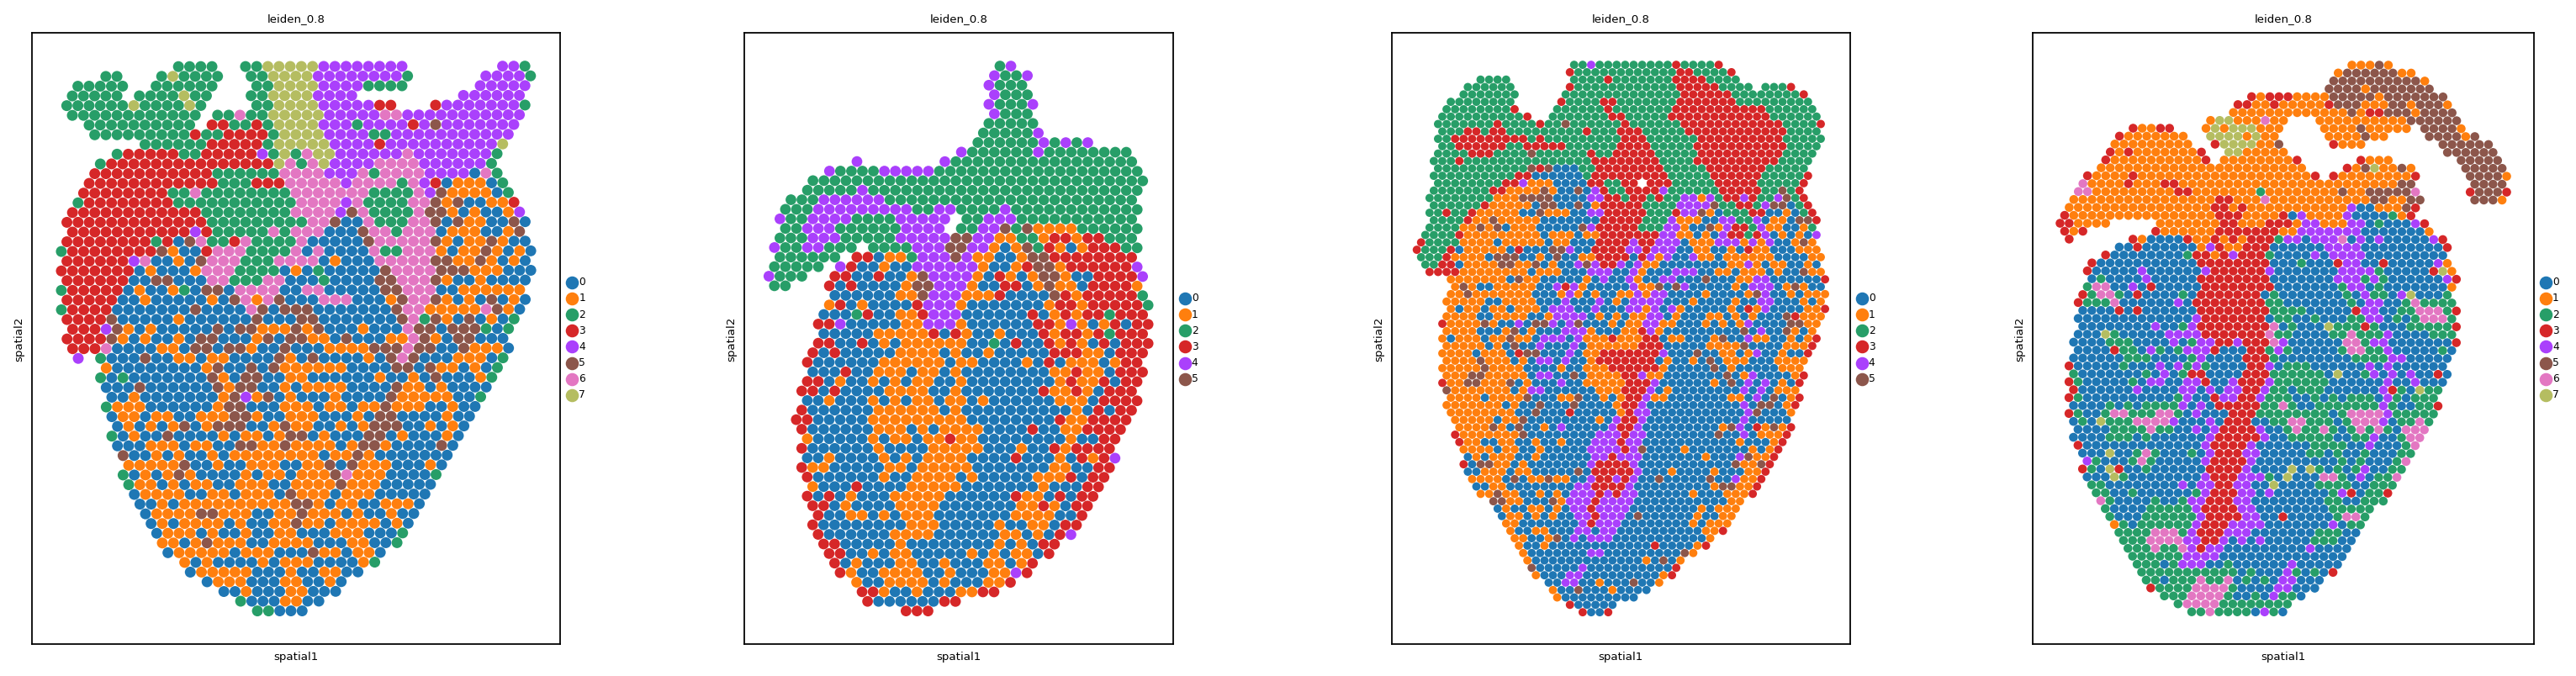

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, library in enumerate(stage_data_visium):
    ad = library.copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=samples[i],
        color="leiden_0.8",
        size=1.5,
        scale_factor=1.0,
        show=False,
        ax=axs[i],
    )
plt.tight_layout()

In [12]:
stage_data_visium[0].obs["anatomical_regions_leiden_0.8"] = stage_data_visium[0].obs["leiden_0.8"]
anatomical_regions = {'0': "Ventricle", 
             '1': "Ventricle", 
             '2': "Chamber cavity",
             '6': "Valve", 
             '3': "Atria",
             '4': "Atria",
             '5': "Ventricle",
             '7': "Outflow tract"}
stage_data_visium[0].obs["anatomical_regions_leiden_0.8"] = stage_data_visium[0].obs["anatomical_regions_leiden_0.8"].map(anatomical_regions).astype("category")
stage_data_visium[1].obs["anatomical_regions_leiden_0.8"] = stage_data_visium[1].obs["leiden_0.8"]
anatomical_regions = {'0': "Inflamed ventricle", 
             '1': "Inflamed ventricle", 
             '2': "Inflamed atria", 
             '3': "Inflamed ventricle",
             '4': "Chamber cavity",
             '5': "Chamber cavity"}
stage_data_visium[1].obs["anatomical_regions_leiden_0.8"] = stage_data_visium[1].obs["anatomical_regions_leiden_0.8"].map(anatomical_regions).astype("category")
stage_data_visium[2].obs["anatomical_regions_leiden_0.8"] = stage_data_visium[2].obs["leiden_0.8"]
anatomical_regions = {'0': "Ventricle", 
             '1': "Ventricle", 
             '2': "Atria", 
             '3': "Chamber cavity",
             '4': "Ventricle",
             '5': "Ventricle"}
stage_data_visium[2].obs["anatomical_regions_leiden_0.8"] = stage_data_visium[2].obs["anatomical_regions_leiden_0.8"].map(anatomical_regions).astype("category")
stage_data_visium[3].obs["anatomical_regions_leiden_0.8"] = stage_data_visium[3].obs["leiden_0.8"]
anatomical_regions = {'0': "Inflamed ventricle", 
             '1': "Inflamed atria", 
             '2': "Peripheral tissue", 
             '3': "Chamber cavity",
             '4': "Chamber cavity",
             '5': "Inflamed atria",
             '6': "Myocarditic region",
             '7': "Outflow tract"}
stage_data_visium[3].obs["anatomical_regions_leiden_0.8"] = stage_data_visium[3].obs["anatomical_regions_leiden_0.8"].map(anatomical_regions).astype("category")

In [13]:
heart_infection_visium_no_viral_genes = stage_data_visium[0].concatenate(
    stage_data_visium[1], stage_data_visium[2], stage_data_visium[3],
    batch_key="sample", 
    uns_merge="unique",
    batch_categories=[
        k
        for d in [
            stage_data_visium[0].uns["spatial"],
            stage_data_visium[1].uns["spatial"],
            stage_data_visium[2].uns["spatial"],
            stage_data_visium[3].uns["spatial"],
        ]
        for k, v in d.items()
    ],
)

In [14]:
heart_infection_visium_no_viral_genes.obs["anatomical_regions_leiden_0.8"] = heart_infection_visium_no_viral_genes.obs["anatomical_regions_leiden_0.8"].astype("category")

... storing 'leiden_0.5' as categorical
... storing 'leiden_0.8' as categorical


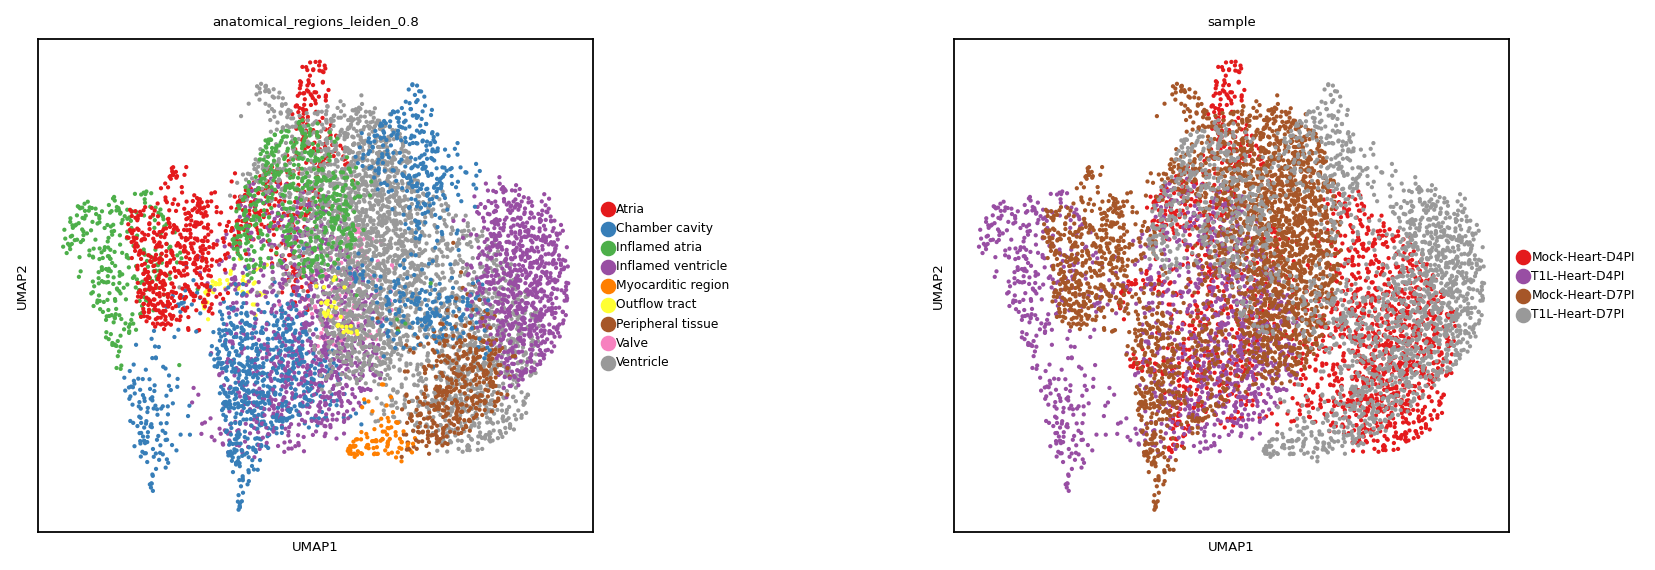

In [15]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(heart_infection_visium_no_viral_genes, color=["anatomical_regions_leiden_0.8", "sample"], wspace=0.5, palette="Set1")


In [16]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], heart_infection_visium_no_viral_genes.uns["anatomical_regions_leiden_0.8_colors"])
)
final_dict = dict(zip(list(heart_infection_visium_no_viral_genes.obs["anatomical_regions_leiden_0.8"].cat.categories), list(clusters_colors.values())))
final_dict
import pickle
with open('anatomical_reions_colors.pickle', 'wb') as handle:
    pickle.dump(final_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/mm2937/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


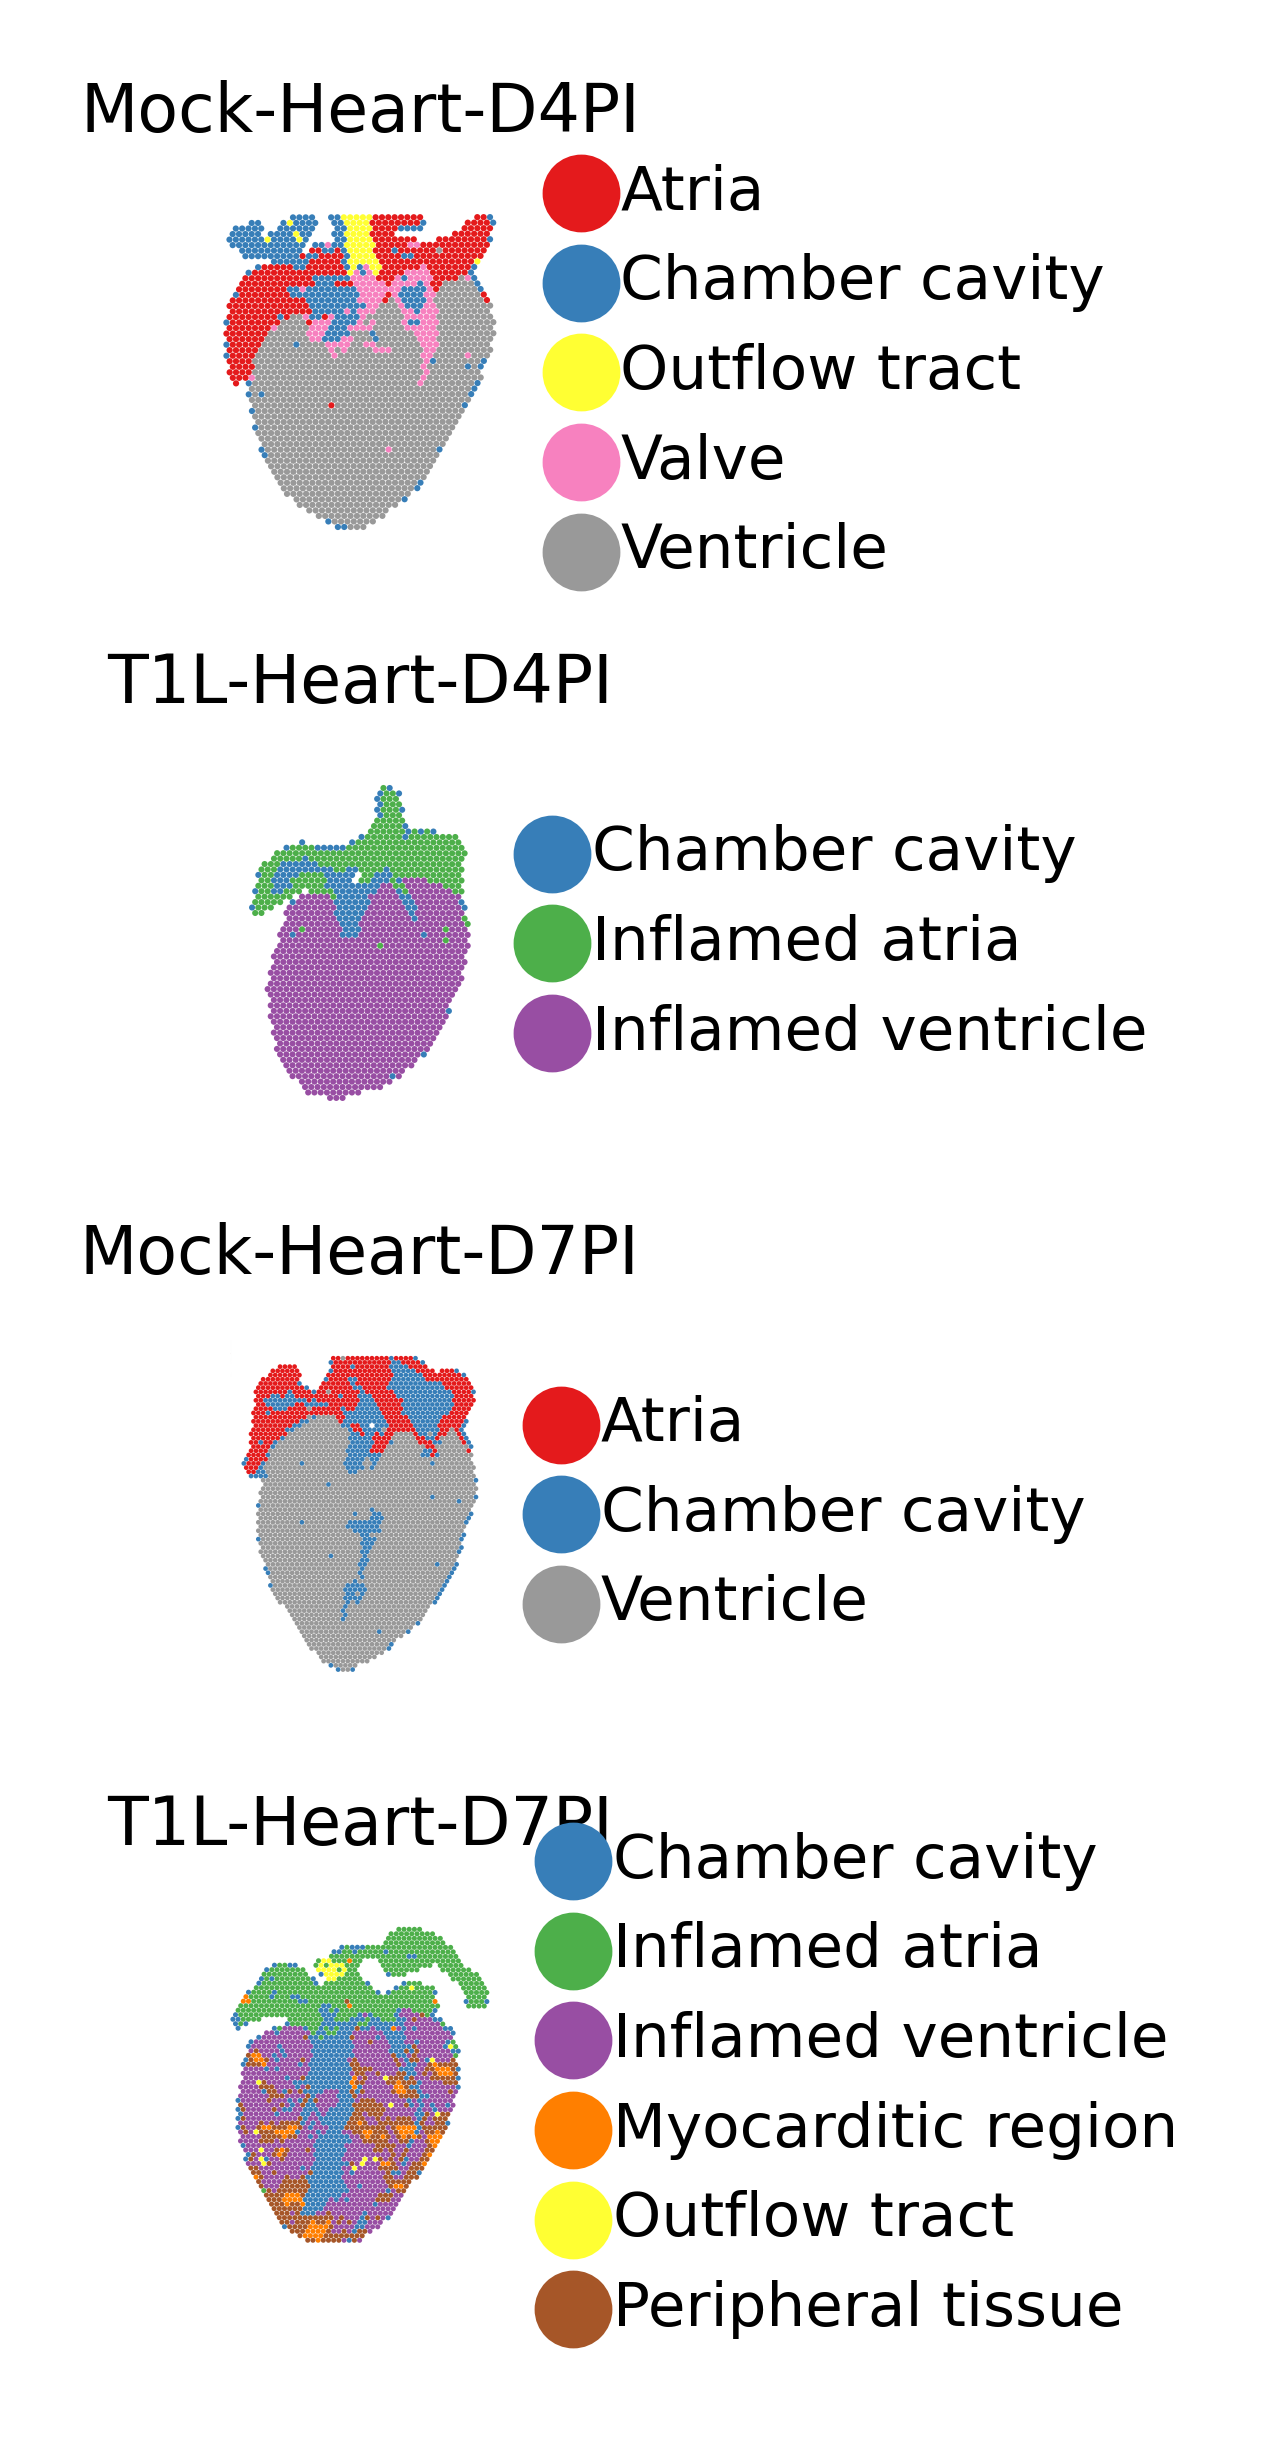

In [17]:
sc.settings.set_figure_params(dpi=400, dpi_save= 400, fontsize=6, frameon=True, figsize=(3, 3), transparent=True, vector_friendly = False, format="pdf")
fig, axs = plt.subplots(4, 1, figsize=(3,3))
for i, library in enumerate(samples):
    ad = heart_infection_visium_no_viral_genes[heart_infection_visium_no_viral_genes.obs["sample"] == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="anatomical_regions_leiden_0.8",
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs["anatomical_regions_leiden_0.8"].unique().tolist()
        ],
        size=1.5,
        scale_factor=0.6,
        show=False,
        ax=axs[i],
        frameon=False, 
        title=library
    )
# for i in range(3):
# axs[i].get_legend().set_visible(False)
# plt.legend(prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, frameon = False, labelspacing = 0.2)
plt.tight_layout()
plt.savefig("figures/spatial_maps.pdf", facecolor='w', edgecolor='w',
        format="pdf",  transparent=True)

In [25]:
stage_data_visium[0].write_h5ad(filename="./../pyobjs/Mock_heart_D4PI.h5ad")
stage_data_visium[1].write_h5ad(filename="./../pyobjs/T1L_heart_D4PI.h5ad")
stage_data_visium[2].write_h5ad(filename="./../pyobjs/Mock_heart_D7PI.h5ad")
stage_data_visium[3].write_h5ad(filename="./../pyobjs/T1L_heart_D7PI.h5ad")

In [18]:
stage_data_visium = list()
stage_data_visium.append(sc.read_h5ad(filename="./../pyobjs/Mock_heart_D4PI.h5ad"))
stage_data_visium.append(sc.read_h5ad(filename="./../pyobjs/T1L_heart_D4PI.h5ad"))
stage_data_visium.append(sc.read_h5ad(filename="./../pyobjs/Mock_heart_D7PI.h5ad"))
stage_data_visium.append(sc.read_h5ad(filename="./../pyobjs/T1L_heart_D7PI.h5ad"))

In [19]:
heart_infection_visium_no_viral_genes = stage_data_visium[0].concatenate(
    stage_data_visium[1], stage_data_visium[2], stage_data_visium[3],
    batch_key="sample", 
    uns_merge="unique",
    batch_categories=[
        k
        for d in [
            stage_data_visium[0].uns["spatial"],
            stage_data_visium[1].uns["spatial"],
            stage_data_visium[2].uns["spatial"],
            stage_data_visium[3].uns["spatial"],
        ]
        for k, v in d.items()
    ],
)

In [141]:
heart_infection_visium_no_viral_genes

AnnData object with n_obs × n_vars = 8243 × 15524
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.5', 'leiden_0.8', 'sample', 'anatomical_regions_leiden_0.8', 'Infection_response_score', 'T1LReoS1_xGen', 'T1LReoS2_xGen', 'T1LReoS3_xGen', 'T1LReoS4_xGen', 'T1LReoM1_xGen', 'T1LReoM2_xGen', 'T1LReoM3_xGen', 'T1LReoL1_xGen', 'T1LReoL2_xGen', 'T1LReoL3_xGen', 'total_viral_xGen', 'pct_viral_xGen', 'total_viral_xGen_NA', 'total_viral_xGen2_NA'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells-Mock-Heart-D4PI', 'n_cells_by_counts-Mock-Heart-D4PI', 'mean_counts-Mock-Heart-D4PI', 'pct_dropout_by_counts-Mock-Heart-D4PI', 'total_counts-Mock-Heart-D4PI', 'mean-Mock-Heart-D4PI', 'std-Mock-Heart-D4PI', 'n_cells-Mock-Heart-D7PI', 'n_cells_by_counts-Mock-Heart-D7PI', 'mean_counts-Mock-Heart-D7PI', 'pct_dropout_by_counts-Mock-Heart-D7PI', 'total_counts-Mock-Heart-D7PI', 'mean-Mock-Heart-D7PI', 'st

In [37]:
# heart_infection_visium_no_viral_genes.write_h5ad(filename="./../pyobjs/heart_infection_visium_no_viral_genes.h5ad")

... storing 'leiden_0.5' as categorical
... storing 'leiden_0.8' as categorical
... storing 'anatomical_regions_leiden_0.8' as categorical


In [90]:
sc.tl.rank_genes_groups(heart_infection_visium_no_viral_genes, 'anatomical_regions_leiden_0.8', method='wilcoxon', key_added='rank_genes_groups_anatomical_regions_leiden_0.8')
sc.tl.dendrogram(heart_infection_visium_no_viral_genes, "anatomical_regions_leiden_0.8", n_pcs=20)

ranking genes
    finished: added to `.uns['rank_genes_groups_anatomical_regions_leiden_0.8']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:18)
    using 'X_pca' with n_pcs = 20
Storing dendrogram info using `.uns['dendrogram_anatomical_regions_leiden_0.8']`


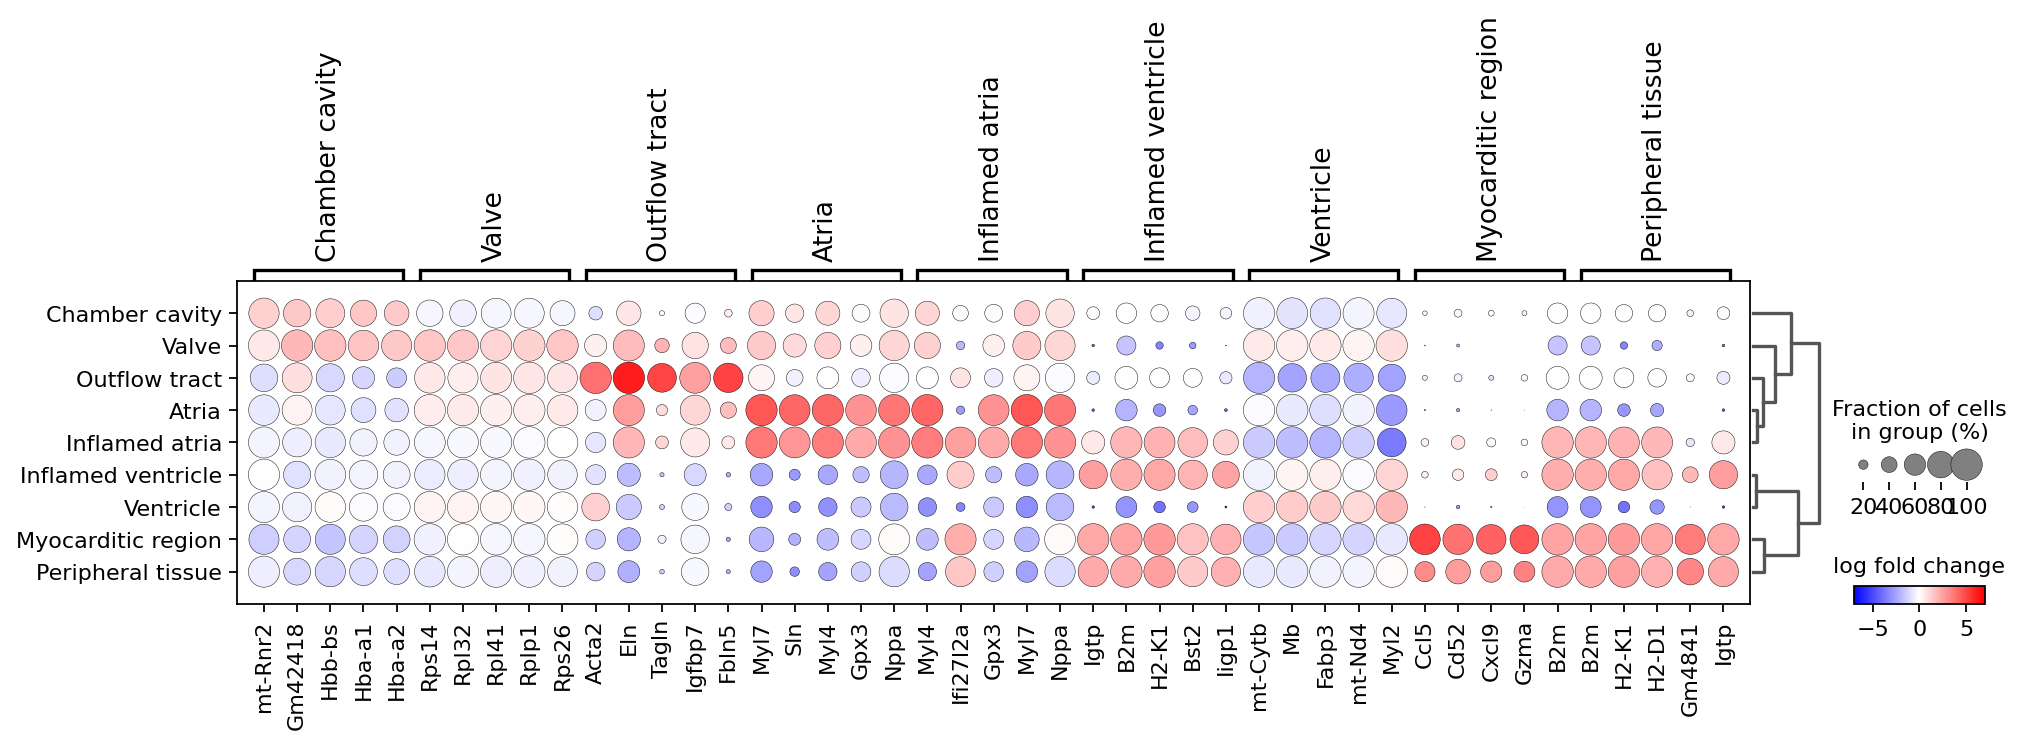

In [100]:
sc.settings.set_figure_params(dpi=80, dpi_save= 600, fontsize=12, frameon=True, figsize=(3, 3), transparent=True, vector_friendly = False, format="pdf")
fig, ax = plt.subplots(figsize = (14,3.5))
sc.pl.rank_genes_groups_dotplot(heart_infection_visium_no_viral_genes, n_genes=5, key="rank_genes_groups_anatomical_regions_leiden_0.8", values_to_plot='logfoldchanges', min_logfoldchange=1.0, vmax=7, vmin=-7, cmap='bwr', show=False, ax=ax)
# plt.tight_layout()
plt.savefig("./figures/anatomical_dotplot.pdf")

In [24]:
day4_WT_infection_markers = pd.read_csv("./../csvs/heart_IFN_genelist_D4PI.csv")
day4_WT_infection_markers_significant = day4_WT_infection_markers[day4_WT_infection_markers["logfoldchanges"] > 1.0]
day4_WT_infection_markers_significant = day4_WT_infection_markers_significant[day4_WT_infection_markers_significant["pvals_adj"] < 0.01]
print(day4_WT_infection_markers_significant)

     Unnamed: 0     names     scores  logfoldchanges     pvals  pvals_adj
0             0    Ifitm3  85.555220        3.635777  0.000000   0.000000
1             1      Bst2  84.066870        5.022720  0.000000   0.000000
2             3     Isg15  79.678000        6.908294  0.000000   0.000000
3             4       B2m  77.476456        3.591180  0.000000   0.000000
4             5  Ifi27l2a  60.614697        5.020513  0.000000   0.000000
..          ...       ...        ...             ...       ...        ...
918         920    Lgals3   3.483982        1.393968  0.000494   0.007769
919         921       Tnf   3.480584        1.848132  0.000500   0.007863
923         925    H2-T24   3.471297        3.921334  0.000518   0.008107
941         943    H2-Eb1   3.425932        1.714389  0.000613   0.009389
944         946      Oas3   3.416467        5.822568  0.000634   0.009683

[230 rows x 6 columns]


In [25]:
sc.tl.score_genes(heart_infection_visium_no_viral_genes, day4_WT_infection_markers_significant["names"], use_raw=True, score_name = 'Infection_response_score')

computing score 'Infection_response_score'
    finished: added
    'Infection_response_score', score of gene set (adata.obs).
    1079 total control genes are used. (0:00:00)


/home/mm2937/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'leiden_0.5' as categorical
... storing 'leiden_0.8' as categorical
... storing 'anatomical_regions_leiden_0.8' as categorical
... storing 'leiden_0.5' as categorical
... storing 'leiden_0.8' as categorical
... storing 'anatomical_regions_leiden_0.8' as categorical
... storing 'leiden_0.5' as categorical
... storing 'leiden_0.8' as categorical
... storing 'anatomical_regions_leiden_0.8' as categorical
... storing 'leiden_0.5' as categorical
... storing 'leiden_0.8' as categorical
... storing 'anatomical_regions_leiden_0.8' as categorical


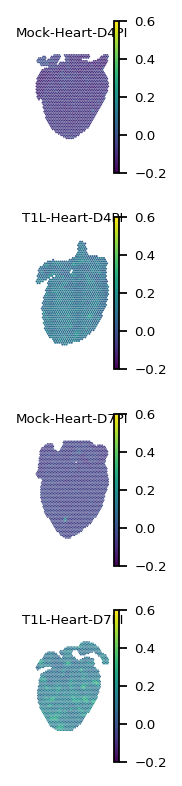

In [27]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize= (2,2.5), facecolor='white', frameon=True, vector_friendly = False, transparent=True, format="pdf")
fig, axs = plt.subplots(4, 1, figsize=(1.0,5))
for i, library in enumerate(samples):
    ad = heart_infection_visium_no_viral_genes[heart_infection_visium_no_viral_genes.obs["sample"] == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=samples[i],
        color="Infection_response_score",
        size=1.5,
        scale_factor=1.0,
        show=False,
        ax=axs[i],
        frameon=False, clim=(-0.20, 0.60), title=samples[i]
    )
plt.tight_layout()
plt.savefig("figures/spatial_IFN.pdf", facecolor='w', edgecolor='w',
        orientation='potrait', format="pdf",
        transparent=True, metadata=None)

In [104]:
iz_markers = sc.get.rank_genes_groups_df(stage_data_visium[3], key='rank_genes_groups_leiden_0.8', group = ["6"])
bz_markers = sc.get.rank_genes_groups_df(stage_data_visium[3], key='rank_genes_groups_leiden_0.8', group = ["2"])
iz_markers.to_csv("./../csvs/iz_markers_d7pi.csv", index = False)
bz_markers.to_csv("./../csvs/bz_markers_d7pi.csv", index = False)

In [105]:
bz_markers[1:50]

names     scores  logfoldchanges         pvals     pvals_adj
1      Hspb7  10.250142        0.744525  1.181697e-24  5.303750e-21
2       Gzma   9.746756        1.324774  1.904587e-22  5.698842e-19
3       Cd52   9.636411        1.015644  5.611603e-22  1.259314e-18
4      Tnnt2   9.116585        0.364124  7.752911e-20  1.546533e-16
5      Actc1   9.013139        0.326523  2.002413e-19  3.594932e-16
6      Ly6c1   8.875836        0.947827  6.940997e-19  1.132834e-15
7     Tmsb4x   8.804289        0.413198  1.316850e-18  1.970117e-15
8       Saa3   8.779204        2.267262  1.646348e-18  2.111206e-15
9    mt-Cytb   8.676312        0.420994  4.088074e-18  4.892879e-15
10      Igtp   8.550296        0.657018  1.227737e-17  1.377598e-14
11      Ccl5   8.528065        1.109851  1.488162e-17  1.571587e-14
12    Ankrd1   8.485008        0.681686  2.157029e-17  2.151396e-14
13    Psmb10   8.404902        0.793612  4.282225e-17  4.046252e-14
14     Cxcl9   8.294386        1.022818  1.091476e-16  9.574842e-14
15       Des   8.291320        0.585762  1.119989e-16  9.574842e-14
16     Psmb8   8.148651        0.708262  3.680073e-16  3.003107e-13
17     Fabp3   8.063049        0.605624  7.441447e-16  5.808534e-13
18     Iigp1   7.881881        0.629269  3.224887e-15  2.315856e-12
19       Mt1   7.609022        0.707409  2.761786e-14  1.857068e-11
20     Gapdh   7.607574        0.358508  2.792895e-14  1.857068e-11
21     Ckmt2   7.543990        0.613482  4.558057e-14  2.922528e-11
22     Acta1   7.507663        1.227799  6.019231e-14  3.726319e-11
23  AW112010   7.497697        0.889149  6.494869e-14  3.886746e-11
24     Irgm1   7.482579        0.765997  7.287827e-14  4.220592e-11
25     Fabp4   7.403152        0.568151  1.329889e-13  7.461091e-11
26    mt-Nd2   7.344254        0.451130  2.069104e-13  1.125655e-10
27    mt-Nd4   7.287910        0.403939  3.147999e-13  1.662236e-10
28     Cryab   7.177608        0.448409  7.094167e-13  3.638902e-10
29     Actn2   7.132593        0.486302  9.849572e-13  4.779172e-10
30       Pln   7.125395        0.605435  1.037824e-12  4.903171e-10
31     Aldoa   7.096947        0.405915  1.275432e-12  5.871238e-10
32      Myl2   7.029488        1.172834  2.072931e-12  9.303833e-10
33    S100a6   6.876002        0.654911  6.155581e-12  2.631218e-09
34     Hspb6   6.790826        0.690091  1.114932e-11  4.549177e-09
35      Actb   6.773493        0.415887  1.257097e-11  5.015259e-09
36     Neat1   6.718129        0.733902  1.840728e-11  7.184042e-09
37      Ly6a   6.710250        0.554765  1.942910e-11  7.421504e-09
38      Nrap   6.700327        0.909456  2.079533e-11  7.777888e-09
39     Psme1   6.556849        0.577059  5.495655e-11  2.013541e-08
40  Sh3bgrl3   6.519202        0.810932  7.068259e-11  2.488166e-08
41      Cd36   6.490625        0.562764  8.548086e-11  2.951227e-08
42     Ly6c2   6.409496        0.982711  1.460018e-10  4.945605e-08
43     Csrp3   6.367376        0.409199  1.922889e-10  6.364362e-08
44       Lbh   6.318614        0.642177  2.639206e-10  8.461010e-08
45    Atpif1   6.288121        0.445331  3.213322e-10  9.777758e-08
46    Acot13   6.225645        0.591272  4.795807e-10  1.411461e-07
47      Myl3   6.219001        0.788101  5.003310e-10  1.448781e-07
48      Irf7   6.186804        0.524568  6.139606e-10  1.722256e-07
49    Mybpc3   6.130844        0.495927  8.741401e-10  2.377794e-07

In [106]:
de_results = iz_markers
de_results = de_results[(de_results["logfoldchanges"] > 0.5) & (de_results["pvals_adj"] < 0.01)]
glist = de_results['names'].squeeze().str.strip().tolist()
print(len(glist))

291


In [107]:
# GO_Biological_Process_2021, KEGG_2019_Mouse, WikiPathways_2019_Mouse
enr_res = gseapy.enrichr(gene_list=glist, 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway', 
                     cutoff = 0.01)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:ba18d3a940c56ce1c36f426b8713b8b1
Done.



In [108]:
enr_res.results[1:50]

Gene_set  \
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   
20  GO_Biological_Process_2021   
21  GO_Biological_Process_2021   
22  GO_Biological_Process_2021   
23  GO_Biological_Process_2021   
24  GO_Biological_Process_2021   
25  GO_Biological_Process_2021   
26  GO_Biological_Process_2021   
27  GO_Biological_Process_2021   
28  GO_Biological_Process_2021   
29  GO_Biological_Process_2021   
30  GO_Biological_Process_2021   
31  GO_Biological_Process_2021   
32  GO_Biological_Process_2021   
33  GO_Biological_Process_2021   
34  GO_Biological_Process_2021   
35  GO_Biological_Process_2021   
36  GO_Biological_Process_2021   
37  GO_Biological_Process_2021   
38  GO_Biological_Process_2021   
39  GO_Biological_Process_2021   
40  GO_Biological_Process_2021   
41  GO_Biological_Process_2021   
42  GO_Biological_Process_2021   
43  GO_Biological_Process_2021   
44  GO_Biological_Process_2021   
45  GO_Biological_Process_2021   
46  GO_Biological_Process_2021   
47  GO_Biological_Process_2021   
48  GO_Biological_Process_2021   
49  GO_Biological_Process_2021   

                                                 Term Overlap       P-value  \
1                cytoplasmic translation (GO:0002181)   36/93  2.943962e-42   
2   cotranslational protein targeting to membrane ...   36/94  4.712021e-42   
3                protein targeting to ER (GO:0045047)  35/103  1.005398e-38   
4   nuclear-transcribed mRNA catabolic process, no...  34/113  1.483223e-35   
5           peptide biosynthetic process (GO:0043043)  34/162  1.022176e-29   
6   nuclear-transcribed mRNA catabolic process (GO...  34/171  7.082732e-29   
7                            translation (GO:0006412)  35/214  1.203778e-26   
8    cytokine-mediated signaling pathway (GO:0019221)  51/621  4.715982e-24   
9     cellular protein metabolic process (GO:0044267)  42/417  2.916898e-23   
10                       gene expression (GO:0010467)  37/356  4.861204e-21   
11  cellular macromolecule biosynthetic process (G...  35/314  6.061828e-21   
12              neutrophil degranulation (GO:0043312)  37/481  1.148958e-16   
13  neutrophil activation involved in immune respo...  37/485  1.501666e-16   
14          neutrophil mediated immunity (GO:0002446)  37/488  1.832302e-16   
15                   ribosome biogenesis (GO:0042254)  24/192  7.975135e-16   
16          response to interferon-gamma (GO:0034341)   17/80  1.637547e-15   
17                rRNA metabolic process (GO:0016072)  22/162  2.263286e-15   
18                       rRNA processing (GO:0006364)  22/173  9.192532e-15   
19  cellular response to interferon-gamma (GO:0071...  19/121  1.259684e-14   
20  cellular response to cytokine stimulus (GO:007...  34/482  2.786196e-14   
21                      ncRNA processing (GO:0034470)  22/201  2.119346e-13   
22  antigen processing and presentation of exogeno...   14/78  6.200223e-12   
23    cellular response to interleukin-1 (GO:0071347)  17/155  1.181437e-10   
24  cellular response to type I interferon (GO:007...   12/65  1.454416e-10   
25   type I interferon signaling pathway (GO:0060337)   12/65  1.454416e-10   
26  antigen processing and presentation of exogeno...   12/73  5.986091e-10   
27  negative regulation of innate immune response ...    9/38  2.908739e-09   
28       regulation of apoptotic process (GO:0042981)  34/742  3.538843e-09   
29  cellular response to tumor

In [130]:
de_results = bz_markers
de_results = de_results[(de_results["logfoldchanges"] > 0.5) & (de_results["pvals_adj"] < 0.01)]
glist = de_results['names'].squeeze().str.strip().tolist()
print(len(glist))

90


In [131]:
# GO_Biological_Process_2021, KEGG_2019_Mouse, WikiPathways_2019_Mouse
enr_res = gseapy.enrichr(gene_list=glist, 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway', 
                     cutoff = 0.01)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:ff6074b4c53063d23df7203cd330be19
Done.



In [132]:
enr_res.results[1:50]

Gene_set  \
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   
20  GO_Biological_Process_2021   
21  GO_Biological_Process_2021   
22  GO_Biological_Process_2021   
23  GO_Biological_Process_2021   
24  GO_Biological_Process_2021   
25  GO_Biological_Process_2021   
26  GO_Biological_Process_2021   
27  GO_Biological_Process_2021   
28  GO_Biological_Process_2021   
29  GO_Biological_Process_2021   
30  GO_Biological_Process_2021   
31  GO_Biological_Process_2021   
32  GO_Biological_Process_2021   
33  GO_Biological_Process_2021   
34  GO_Biological_Process_2021   
35  GO_Biological_Process_2021   
36  GO_Biological_Process_2021   
37  GO_Biological_Process_2021   
38  GO_Biological_Process_2021   
39  GO_Biological_Process_2021   
40  GO_Biological_Process_2021   
41  GO_Biological_Process_2021   
42  GO_Biological_Process_2021   
43  GO_Biological_Process_2021   
44  GO_Biological_Process_2021   
45  GO_Biological_Process_2021   
46  GO_Biological_Process_2021   
47  GO_Biological_Process_2021   
48  GO_Biological_Process_2021   
49  GO_Biological_Process_2021   

                                                 Term Overlap       P-value  \
1   cellular response to tumor necrosis factor (GO...  13/194  3.840769e-12   
2     cellular response to interleukin-1 (GO:0071347)  12/155  4.969603e-12   
3   antigen processing and presentation of exogeno...    9/73  3.851986e-11   
4   antigen processing and presentation of exogeno...    9/78  7.104859e-11   
5   regulation of cellular ketone metabolic proces...    8/64  4.409393e-10   
6   tumor necrosis factor-mediated signaling pathw...   9/116  2.585096e-09   
7   regulation of cellular amine metabolic process...    7/51  2.904640e-09   
8   regulation of cellular amino acid metabolic pr...    7/54  4.395033e-09   
9   Wnt signaling pathway, planar cell polarity pa...    8/85  4.440470e-09   
10  regulation of establishment of planar polarity...    8/88  5.866265e-09   
11  negative regulation of cell cycle G2/M phase t...    7/57  6.490011e-09   
12  negative regulation of mitotic cell cycle phas...    8/92  8.371935e-09   
13  interleukin-1-mediated signaling pathway (GO:0...    8/94  9.939135e-09   
14      pre-replicative complex assembly (GO:0036388)    7/64  1.486626e-08   
15  negative regulation of G2/M transition of mito...    7/66  1.850216e-08   
16  regulation of hematopoietic stem cell differen...    7/71  3.102607e-08   
17  proteasomal ubiquitin-independent protein cata...    5/22  4.087594e-08   
18               NIK/NF-kappaB signaling (GO:0038061)    7/74  4.152858e-08   
19  regulation of hematopoietic progenitor cell di...    7/75  4.563744e-08   
20  regulation of transcription from RNA polymeras...    7/75  4.563744e-08   
21  regulation of mRNA catabolic process (GO:0061013)   8/122  7.762127e-08   
22   non-canonical Wnt signaling pathway (GO:0035567)   8/124  8.810102e-08   
23  anaphase-promoting complex-dependent catabolic...    7/84  1.007934e-07   
24  regulation of transcription from RNA polymeras...    7/87  1.286243e-07   
25  SCF-dependent proteasomal ubiquitin-dependent ...    7/89  1.505708e-07   
26  regulation of stem cell differentiation (GO:20...    7/91  1.755947e-07   
27  regulation of cell cycle phase transition (GO:...    7/95  2.362668e-07   
28          regulation of mRNA stability (GO:0043488)   8/146  3.111038e-07   
29     T cell receptor signali

(1036, 11)


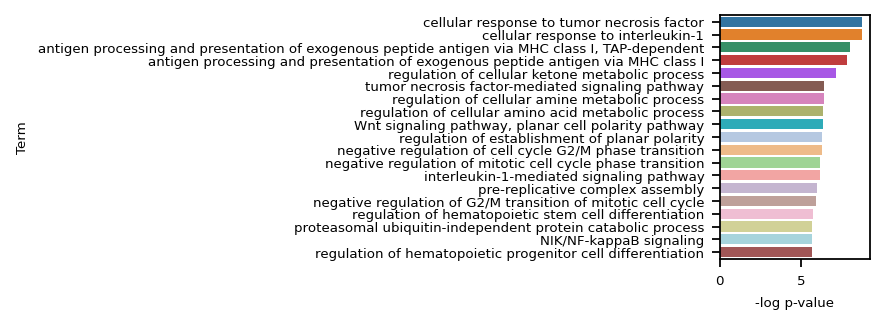

In [53]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
# GO_results = GO_results.iloc[[1,12,24,26,28,32,33,36,38,40,54,56,59,60,68,69,86,93,163,210],]
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
print(GO_results.shape)

sc.settings.set_figure_params(dpi_save= 400, fontsize=6, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(1.2,2.0))
plt.rc('font', size=6)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[1:20], ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
# plt.tight_layout()
# plt.show()
plt.savefig("figures/go_enrich_bz_genes.pdf", facecolor='w', edgecolor='w',
        orientation='potrait', format="pdf",
        transparent=True, metadata=None)

In [133]:
[x.capitalize() for x in enr_res.results.loc[39,"Genes"].split(";")]

['Psmc5', 'Psma3', 'Psma4', 'Psme1', 'Psmb10', 'Psmb8', 'Psmb9']

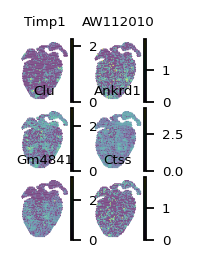

In [59]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(0.5,0.5), facecolor='white', frameon=True, transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(stage_data_visium[3], color= ["Timp1", "AW112010", "Clu", "Ankrd1", "Gm4841", "Ctss"], ncols=2, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1, save="spatial_ge_bz.pdf")

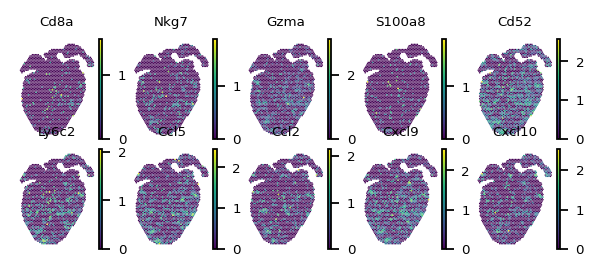

In [88]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(0.8,0.8), facecolor='white', frameon=True, transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(stage_data_visium[3], color= ["Cd8a", "Nkg7", "Gzma", "S100a8", "Cd52", "Ly6c2", "Ccl5", "Ccl2", "Cxcl9", "Cxcl10"], ncols=5, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1, save="spatial_ge_iz.pdf")

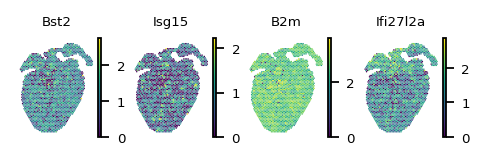

In [110]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(0.8,0.8), facecolor='white', frameon=True, transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(stage_data_visium[3], color= ["Bst2", "Isg15", "B2m", "Ifi27l2a"], ncols=4, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1, save="spatial_ge_ifn.pdf")

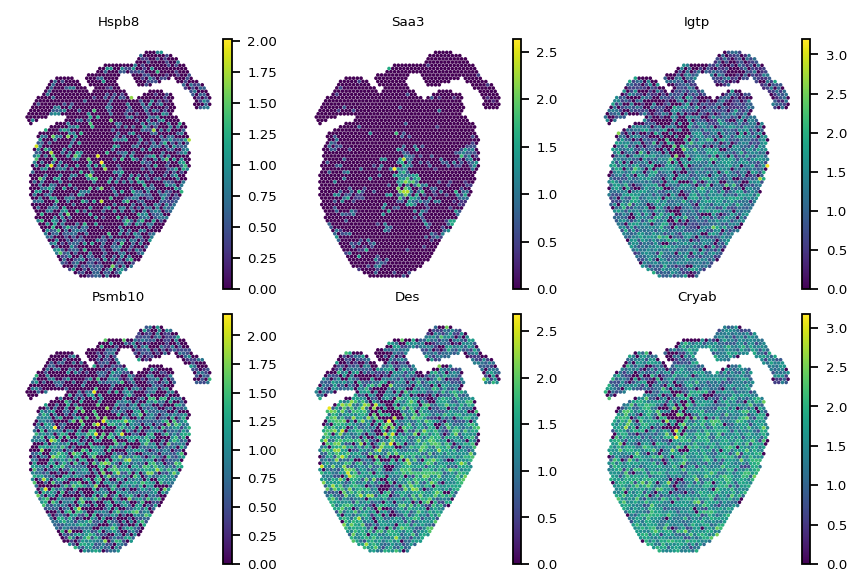

In [66]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(2.0,2.0), facecolor='white', frameon=True, transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(stage_data_visium[3], color= ["Hspb8", "Saa3", "Igtp", "Psmb10", "Des", "Cryab"], ncols=3, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1, save="spatial_ge_supp_bz.pdf")

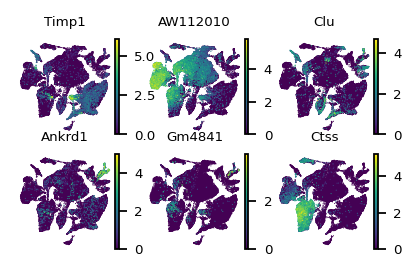

In [115]:
sc.settings.set_figure_params(dpi_save= 600, fontsize=6, figsize= (0.8,0.8), facecolor='white', frameon=True, vector_friendly = True, transparent=True, format="pdf")
sc.pl.umap(heart_infection_sc_no_viral_genes, color=  ["Timp1", "AW112010", "Clu", "Ankrd1", "Gm4841", "Ctss"], size=1.0, hspace=0.2, wspace=0.2, ncols=3, frameon=False, save = "bz_sc_se.pdf")

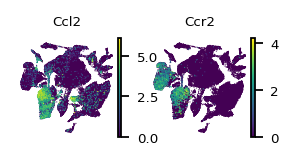

In [103]:
sc.settings.set_figure_params(dpi_save= 600, fontsize=6, figsize= (0.8,0.8), facecolor='white', frameon=True, vector_friendly = True, transparent=True, format="pdf")
sc.pl.umap(heart_infection_sc_no_viral_genes, color= ["Ccl2", "Ccr2"], size=1.0, hspace=0.2, wspace=0.2, ncols=3, frameon=False, save = "ccl2ccr2_sc_exp.pdf")

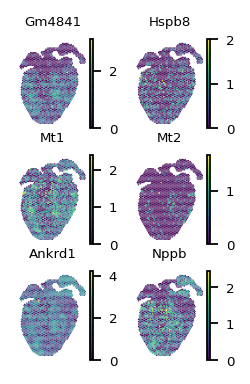

In [116]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(0.8,0.8), facecolor='white', frameon=True, transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(stage_data_visium[3], color= ["Gm4841", "Hspb8", "Mt1", "Mt2", "Ankrd1", "Nppb"], ncols=2, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.3, wspace=0.1, save="spatial_myocyte_ge_bz2.pdf")

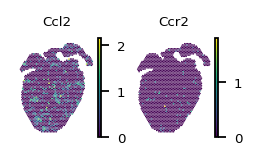

In [102]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(0.8,0.8), facecolor='white', frameon=True, transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(stage_data_visium[3], color= ["Ccl2", "Ccr2"], ncols=3, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.3, wspace=0.1, save="spatial_ccl2ccr2_ge.pdf")

/home/mm2937/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


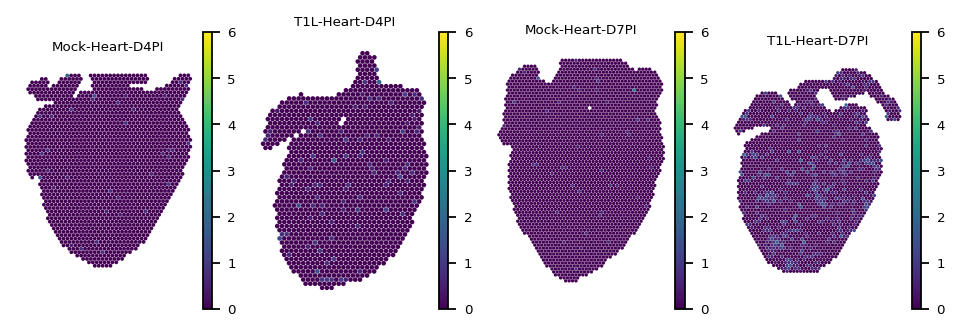

In [134]:
#  ["Gm4841", "Gm12185", "Zbp1", "Mt1", "Mt2", "Saa3", "Ankrd1", 
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize= (2,2), facecolor='white', frameon=True, vector_friendly = False, transparent=True, format="pdf")
fig, axs = plt.subplots(1,4, figsize=(6,2))
for i, library in enumerate(samples):
    ad = heart_infection_visium_no_viral_genes[heart_infection_visium_no_viral_genes.obs["sample"] == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=samples[i],
        color="Ccl2",
        size=1.5,
        scale_factor=1.0,
        show=False,
        ax=axs[i],
        frameon=False, title=samples[i], clim=(0,6)
    )
plt.tight_layout()

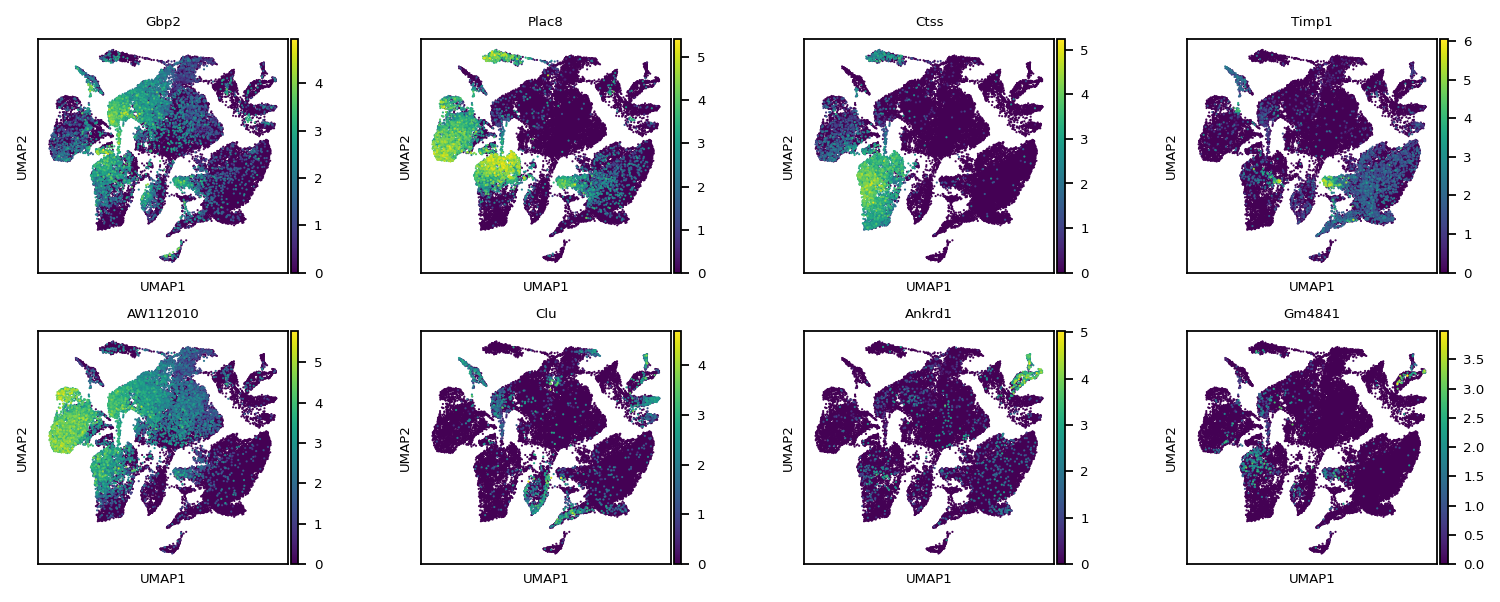

In [216]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize= (2,2), facecolor='white', frameon=True, vector_friendly = False, transparent=True, format="pdf")
sc.pl.umap(heart_infection_sc_no_viral_genes, color= ["Gbp2", "Plac8", "Ctss", "Timp1", "AW112010", "Clu", "Ankrd1", "Gm4841"])